## transferlearning004.ipynb
#### Model 03을 만들 예정 (fine-tuning transfer learning)
#### Model 02는 전체 데이터의 10%, 그리고 data augmentation을 적용해 epoch 5로 전이 학습 실행.
#### base model 의 가중치를 변경하지 않았습니다.


#### fine-tuning의 의미는 자신의 데이터로 사전에 학습된 모델을 자신의 데이터에 맞도록 하는 과정

In [1]:
from helper_functions import unzip_data, walk_through_dir, create_tensorboard_callback, plot_loss_curves

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# 데이터 다운로드
!wget -q https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

In [4]:
# 10_food_classes_10_percent.zip 압축 해제
unzip_data("10_food_classes_10_percent.zip")

In [5]:
walk_through_dir("10_food_classes_10_percent")

10_food_classes_10_percent 폴더에는 2개의 폴더와 0개의 파일이 존재합니다.
10_food_classes_10_percent/test 폴더에는 10개의 폴더와 0개의 파일이 존재합니다.
10_food_classes_10_percent/test/ice_cream 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent/test/chicken_curry 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent/test/steak 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent/test/sushi 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent/test/chicken_wings 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent/test/grilled_salmon 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent/test/hamburger 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent/test/pizza 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent/test/ramen 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent/test/fried_rice 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent/train 폴더에는 10개의 폴더와 0개의 파일이 존재합니다.
10_food_classes_10_percent/train/ice_cream 폴더에는 0개의 폴더와 75개의 파일이 존재합니다.
10_food_classes_10_percent/train

In [6]:
# 상수 선언
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCH_COUNT = 5

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir_10_percent = "10_food_classes_10_percent/test/"

In [7]:
# 데이터 셋 준비
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir_10_percent,
    image_size = IMAGE_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir_10_percent,
    image_size = IMAGE_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [7]:
# Data Augmentation
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomWidth(0.2)
], name="data_augmentation")

In [8]:
# Model 2 : 10%의 데이터 + Data Augmentation 

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape = input_shape, name = "model_2_input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name = "model_2_global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation = "softmax", name = "model_2_output_layer")(x)

model_2 = keras.Model(inputs, outputs)


# 컴파일과 fitting
model_2.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [9]:
# checkpoint 위치 지정
checkpoint_path = "10_percent_model_checkpoints_weights/chechpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    save_weights_only = True, # 전체 모델을 저장하려면 False로 지정
    save_best_only = False, # 각 epoch의 모델 대신 최적화 된 모델을 지정하려면 True로 지정
    save_freq = "epoch", # 매 epoch 저장
)

In [10]:
model_2.load_weights(checkpoint_path)


In [22]:
print(type(model_2.layers))
model_2.layers


<class 'list'>


In [18]:
[ print(layer.trainable) for layer in model_2.layers ]
# for layer in model_2.layers:
#     print(layer.trainable)   

# input_layer : 입력층
# sequential : data augmentation
# functional : base model (EfficientNetB0)

True
True
False
True
True


[None, None, None, None, None]

In [19]:
model_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2_input_layer (InputLa [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, 224, None, 3)      0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
model_2_global_average_pooli (None, 1280)              0         
_________________________________________________________________
model_2_output_layer (Dense) (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [26]:
print(len(model_2.layers[2].trainable_variables))

0


In [25]:
print(len(base_model.trainable_variables))

0


In [30]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number,  layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [32]:
len(base_model.layers[:-10])

227

In [33]:
base_model.trainable = True

In [35]:
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [36]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number,  layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [37]:

# 컴파일과 fitting
model_2.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [40]:
print(len(model_2.trainable_variables)) # 학습할수 있는 애들

12


In [41]:
fine_tune_epoch = EPOCH_COUNT + 5

history_10_percent_data_augment_fine_tuning = model_2.fit(
    train_data_10_percent,
    epochs = fine_tune_epoch,
    steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data_10_percent,
    validation_steps = len(test_data_10_percent),
    callbacks = [
        create_tensorboard_callback("transfer_learning", "10_percent_data_augment_fine_tuning"),
        checkpoint_callback
    ]
)

TensorBoard 로그 파일을 저장한 디렉토리 : transfer_learning/10_percent_data_augment_fine_tuning/20210620-140329
Epoch 1/10
24/24 [==============================] - 164s 7s/step - loss: 0.8422 - accuracy: 0.7253 - val_loss: 0.5607 - val_accuracy: 0.8180
Epoch 2/10
24/24 [==============================] - 140s 6s/step - loss: 0.4845 - accuracy: 0.8480 - val_loss: 0.5688 - val_accuracy: 0.8112
Epoch 3/10
24/24 [==============================] - 147s 6s/step - loss: 0.2677 - accuracy: 0.9147 - val_loss: 0.6350 - val_accuracy: 0.8012
Epoch 4/10
24/24 [==============================] - 152s 7s/step - loss: 0.2115 - accuracy: 0.9333 - val_loss: 0.5736 - val_accuracy: 0.8252
Epoch 5/10
24/24 [==============================] - 140s 6s/step - loss: 0.1625 - accuracy: 0.9600 - val_loss: 0.5828 - val_accuracy: 0.8292
Epoch 6/10
24/24 [==============================] - 148s 6s/step - loss: 0.1193 - accuracy: 0.9640 - val_loss: 0.5813 - val_accuracy: 0.8348
Epoch 7/10
24/24 [==============================] - 14

In [48]:
result_10_percent_data_augment_fine_tuning = model_2.evaluate(test_data_10_percent)
result_10_percent_data_augment_fine_tuning

79/79 [==============================] - 130s 2s/step - loss: 0.7082 - accuracy: 0.8108


[0.7082114815711975, 0.8108000159263611]

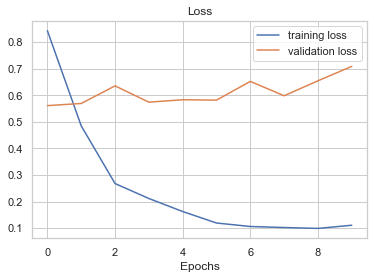

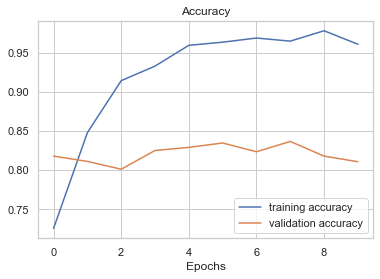

In [47]:
plot_loss_curves(history_10_percent_data_augment_fine_tuning)

In [53]:
# 비교할 수 있는 함수
def compare_historys(original_history, new_history, inital_epochs = 5):
    acc = original_history.history["accuracy"] 
    loss = original_history.history["loss"] 

    print(len(acc))

    val_acc = original_history.history["val_accuracy"] 
    val_loss = original_history.history["val_loss"] 

    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc, label="Training Accuracy")
    plt.plot(total_val_acc, label = "Validation Accuracy")
    plt.plot(
        [initial_epochs-1, initial_epochs-1],
        plot.ylim(),
        label = "Start Fine Tuning"
        )
    plt.legend(loc = "lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(2,1,2)
    plt.plot(total_acc, label="Training Loss")
    plt.plot(total_val_acc, label = "Validation Loss")
    plt.plot(
        [initial_epochs-1, initial_epochs-1],
        plt.ylim(),
        label = "Start Fine Tuning"
        )
    plt.legend(loc = "upper right")
    plt.title("Training and Validation Loss")
    plt.xlabel("epoch")
    plt.show()


In [50]:
# Model 2 : 10%의 데이터 + Data Augmentation 

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape = input_shape, name = "model_2_input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name = "model_2_global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation = "softmax", name = "model_2_output_layer")(x)

model_2 = keras.Model(inputs, outputs)


# 컴파일과 fitting
model_2.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

history_10_percent_data_augment = model_2.fit(
    train_data_10_percent,
    epochs = EPOCH_COUNT,
    steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data_10_percent,
    validation_steps = len(test_data_10_percent),
    callbacks = [
        create_tensorboard_callback("transfer_learning", "10_percent_data_augment"),
    ]
)

TensorBoard 로그 파일을 저장한 디렉토리 : transfer_learning/10_percent_data_augment/20210620-144320
Epoch 1/5
24/24 [==============================] - 213s 9s/step - loss: 2.0483 - accuracy: 0.3200 - val_loss: 1.5323 - val_accuracy: 0.6180
Epoch 2/5
24/24 [==============================] - 177s 8s/step - loss: 1.4187 - accuracy: 0.6440 - val_loss: 1.1201 - val_accuracy: 0.7400
Epoch 3/5
24/24 [==============================] - 164s 7s/step - loss: 1.1375 - accuracy: 0.6947 - val_loss: 0.9241 - val_accuracy: 0.7684
Epoch 4/5
24/24 [==============================] - 174s 7s/step - loss: 0.9674 - accuracy: 0.7467 - val_loss: 0.8137 - val_accuracy: 0.7844
Epoch 5/5
24/24 [==============================] - 197s 8s/step - loss: 0.8654 - accuracy: 0.7747 - val_loss: 0.7471 - val_accuracy: 0.7920


In [55]:
compare_historys(
    original_history = history_10_percent_data_augment, 
    new_history = history_10_percent_data_augment_fine_tuning,
    inital_epochs = 5
)

5
15
[0.3199999928474426, 0.6439999938011169, 0.6946666836738586, 0.746666669845581, 0.7746666669845581, 0.7253333330154419, 0.8479999899864197, 0.9146666526794434, 0.9333333373069763, 0.9599999785423279, 0.9639999866485596, 0.9693333506584167, 0.9653333425521851, 0.9786666631698608, 0.9613333344459534]


NameError: name 'initial_epochs' is not defined

In [56]:
# Model 4 : 전체 데이터

In [58]:
!wget - q https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2021-06-20 15:04:55--  http://-/
Resolving - (-)... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address `-'
--2021-06-20 15:04:55--  http://q/
Resolving q (q)... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address `q'
--2021-06-20 15:04:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 34.64.4.48, 34.64.4.112, 34.64.4.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|34.64.4.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: `10_food_classes_all_data.zip'

10_food_classes_all 100%[===================>] 495.13M  31.9MB/s    in 18s     

2021-06-20 15:05:14 (27.8 MB/s) - `10_food_classes_all_data.zip' saved [519183241/519183241]

FINISHED --2021-06-20 15:05:14--
Total wall clock time: 18s
Downloaded: 1 files, 495M in 

In [59]:
unzip_data("10_food_classes_all_data.zip")

In [60]:
walk_through_dir("10_food_classes_all_data")

10_food_classes_all_data 폴더에는 2개의 폴더와 0개의 파일이 존재합니다.
10_food_classes_all_data/test 폴더에는 10개의 폴더와 0개의 파일이 존재합니다.
10_food_classes_all_data/test/ice_cream 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_all_data/test/chicken_curry 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_all_data/test/steak 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_all_data/test/sushi 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_all_data/test/chicken_wings 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_all_data/test/grilled_salmon 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_all_data/test/hamburger 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_all_data/test/pizza 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_all_data/test/ramen 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_all_data/test/fried_rice 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_all_data/train 폴더에는 10개의 폴더와 0개의 파일이 존재합니다.
10_food_classes_all_data/train/ice_cream 폴더에는 0개의 폴더와 750개의 파일이 존재합니다.
10_food_classes_all_data/train/chicken_curry 폴더에는 0개의 폴더와 7

In [61]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCH_COUNT = 5

train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [62]:
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode = "categorical",
    image_size = IMAGE_SIZE,
)

test_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode = "categorical",
    image_size = IMAGE_SIZE
)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [63]:
model_2.evaluate(test_data_10_classes_full)

79/79 [==============================] - 121s 2s/step - loss: 0.7471 - accuracy: 0.7920


[0.7470558881759644, 0.7919999957084656]

In [64]:
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 model_2_input_layer True
1 data_augmentation True
2 efficientnetb0 False
3 model_2_global_average_pooling_layer True
4 model_2_output_layer True


In [65]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False



In [66]:
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 model_2_input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 model_2_global_average_pooling_layer True
4 model_2_output_layer True


In [67]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number,  layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [68]:
# 데이터 10배 증가 (750장 이미지 -> 7500장 이미지)

# 컴파일과 fitting
model_2.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

history_10_classese_full = model_2.fit(
    train_data_10_classes_full,
    epochs = EPOCH_COUNT + 5,
    steps_per_epoch = len(train_data_10_classes_full),
    validation_data = test_data_10_classes_full,
    validation_steps = len(test_data_10_classes_full),
    callbacks = [
        create_tensorboard_callback("transfer_learning", "10_classes_full"),
    ]
)

TensorBoard 로그 파일을 저장한 디렉토리 : transfer_learning/10_classes_full/20210620-151927
Epoch 1/10
235/235 [==============================] - 529s 2s/step - loss: 0.7276 - accuracy: 0.7628 - val_loss: 0.3944 - val_accuracy: 0.8744
Epoch 2/10
235/235 [==============================] - 465s 2s/step - loss: 0.5193 - accuracy: 0.8325 - val_loss: 0.3577 - val_accuracy: 0.8820
Epoch 3/10
235/235 [==============================] - 436s 2s/step - loss: 0.4280 - accuracy: 0.8580 - val_loss: 0.3646 - val_accuracy: 0.8768
Epoch 4/10
235/235 [==============================] - 414s 2s/step - loss: 0.3538 - accuracy: 0.8823 - val_loss: 0.3790 - val_accuracy: 0.8776
Epoch 5/10
235/235 [==============================] - 414s 2s/step - loss: 0.3108 - accuracy: 0.8967 - val_loss: 0.3052 - val_accuracy: 0.9020
Epoch 6/10
235/235 [==============================] - 406s 2s/step - loss: 0.2711 - accuracy: 0.9095 - val_loss: 0.3591 - val_accuracy: 0.8836
Epoch 7/10
235/235 [==============================] - 424s 2s/